# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql import Window
import pyspark.sql.functions as F
from pyspark.ml.classification import LinearSVC, LogisticRegression, NaiveBayes, GBTClassifier, RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML
import pandas as pd
from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.stats.weightstats import ztest

In [2]:
# create a Spark session
spark = SparkSession.builder.getOrCreate()

# 1. Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')

## 1.1 Preview data

In [4]:
df.show(5, truncate=False)

+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+-----------------------------+------+-------------+---------------------------------------------------------------------------------------------------------------+------+
|artist          |auth     |firstName|gender|itemInSession|lastName|length   |level|location                      |method|page    |registration |sessionId|song                         |status|ts           |userAgent                                                                                                      |userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+-----------------------------+------+-------------+---------------------------------------------------------------------------------------------------------------+------+
|Martha Tilston  |Logg

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



## 1.2 Clean data

In [6]:
df.count()

286500

In [7]:
print('Number of null value on each column')
df.select(
    [F.count(F.when(F.col(c).isNull() | F.col(c).eqNullSafe(''), 1)).alias(c) for c in df.columns]
).show()

Number of null value on each column
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|  8346|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [8]:
# preview null values data
df.where('song is null').show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null|Logged In|    Micah|  

In [9]:
# preview null users data
df.where('userId = ""').show(5)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [10]:
df = df.dropna(subset=['userId', 'sessionId'])
df = df.where('userId != ""')

In [11]:
df.count()

278154

In [12]:
print('Number of null value on each column after clean data')
df.select(
    [F.count(F.when(F.col(c).isNull() | F.col(c).eqNullSafe(''), 1)).alias(c) for c in df.columns]
).show()

Number of null value on each column after clean data
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



# 2. Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

## 2.1 Define Churn

In [13]:
df.groupby(['page']).count().sort('count', ascending=False).show(truncate=False)

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|NextSong                 |228108|
|Thumbs Up                |12551 |
|Home                     |10082 |
|Add to Playlist          |6526  |
|Add Friend               |4277  |
|Roll Advert              |3933  |
|Logout                   |3226  |
|Thumbs Down              |2546  |
|Downgrade                |2055  |
|Settings                 |1514  |
|Help                     |1454  |
|Upgrade                  |499   |
|About                    |495   |
|Save Settings            |310   |
|Error                    |252   |
|Submit Upgrade           |159   |
|Submit Downgrade         |63    |
|Cancel                   |52    |
|Cancellation Confirmation|52    |
+-------------------------+------+



In [14]:
def is_churn(page):
    return 1 if page == 'Cancellation Confirmation' else 0    
    

udf_is_churn = F.udf(is_churn, StringType())


df = df.withColumn('churn', udf_is_churn(F.col('page')))
df = df.withColumn('churn', F.sum('churn').over(
    Window.partitionBy('userId').orderBy('ts').rowsBetween(Window.unboundedPreceding, 0)
))

For each customer, we calculate their information, which are:
  - is_churn: churned user or or not (predicted target)
  - gender: user gender (M, F)
  - firstName: user first name 
  - lastName: user last name
  - location: user location
  - n_req: Total request number of user
  - n_session: Number of sessions of user
  - n_artist: Number of unique artists that user listened to
  - n_song: Number of unique songs that user listened to
  - ser_days: Number of days that we provide service to user since registered
  - avg_length: Average length of song that user listened to
  - n_thumb_up: Number of thumb up (like) from user
  - n_thumb_down: Number of thumb down (dislike) from user

In [15]:
df_user_summary = df.groupby(['userId', 'gender', 'firstName', 'lastName', 'location']).agg(
    F.max(F.col('churn')).alias('is_churn'),
    F.count(F.col('churn')).alias('n_req'),
    F.countDistinct(F.col('sessionId')).alias('n_session'),
    F.countDistinct(F.col('artist')).alias('n_artist'),
    F.countDistinct(F.col('song')).alias('n_song'),    
    ((F.max('ts')-F.min('registration'))/86400/1000).alias('ser_days'),
    F.mean(F.col('length')).alias('avg_length'),    
    F.count(F.when(F.col('page')=='Thumbs Up', 1)).alias('n_thumb_up'),    
    F.count(F.when(F.col('page')=='Thumbs Down', 1)).alias('n_thumb_down')
).repartition(12)
df_user_summary.cache()

DataFrame[userId: string, gender: string, firstName: string, lastName: string, location: string, is_churn: double, n_req: bigint, n_session: bigint, n_artist: bigint, n_song: bigint, ser_days: double, avg_length: double, n_thumb_up: bigint, n_thumb_down: bigint]

In [16]:
df_user_summary.where('is_churn = 1').sort('n_req').show()

+------+------+---------+---------+--------------------+--------+-----+---------+--------+------+------------------+------------------+----------+------------+
|userId|gender|firstName| lastName|            location|is_churn|n_req|n_session|n_artist|n_song|          ser_days|        avg_length|n_thumb_up|n_thumb_down|
+------+------+---------+---------+--------------------+--------+-----+---------+--------+------+------------------+------------------+----------+------------+
|   125|     M|    Mason|     Hart|  Corpus Christi, TX|     1.0|   11|        1|       8|     8| 71.31688657407408|261.13913750000006|         0|           0|
|100011|     M|Sebastian|     Ball|          Albany, OR|     1.0|   23|        1|      11|    11| 5.165115740740741|258.33631818181817|         0|           1|
|100024|     M| Jonathon|   Miller|New York-Newark-J...|     1.0|   36|        1|      22|    22| 27.22165509259259|234.56963954545455|         5|           0|
|100006|     F|    Leyla|   Barnes|     

## 2.2 Explore data

The churn ratio is ~23%

In [17]:
df_user_summary.groupby('is_churn').count().show()

+--------+-----+
|is_churn|count|
+--------+-----+
|     0.0|  173|
|     1.0|   52|
+--------+-----+



In [18]:
df_user_summary_pd = df_user_summary.toPandas()

In [19]:
df_user_summary_pd.head()

,userId,gender,firstName,lastName,location,is_churn,n_req,n_session,n_artist,n_song,ser_days,avg_length,n_thumb_up,n_thumb_down
0,41,F,Brisa,Murray,"Manchester-Nashua, NH",0.0,2220,12,1319,1699,110.772477,250.211240,76,10
1,126,M,Daelin,Turner,"New York-Newark-Jersey City, NY-NJ-PA",0.0,3102,30,1643,2229,62.095694,251.780989,135,21
2,300005,F,Gabriella,Robinson,"Roanoke, VA",0.0,394,6,288,305,157.055463,246.873267,35,4
3,128,M,Caleb,Pena,"Fairbanks, AK",0.0,2067,17,1163,1539,95.331690,248.522736,87,18
4,300009,F,Lauren,Boone,"St. Louis, MO-IL",0.0,1721,18,1025,1302,101.224109,250.550590,132,15


Let's do bivariate analysis for candidate features with churned label. The features is divided into two types:
  - Numerical features
    - n_req
    - n_session
    - n_artist
    - n_song
    - ser_days
    - avg_length
    - n_thumb_up
    - n_thumb_down
  - Categorical features
    - gender

### 2.2.1 Numerical features

,n_req_churn,n_req_not_churn
count,52.000000,173.000000
mean,862.769231,1348.497110
std,852.262378,1425.428637
min,11.000000,6.000000
25%,208.750000,321.000000
50%,576.000000,940.000000
75%,1154.000000,2005.000000
max,3603.000000,9632.000000


t_stat = -2.3328782065735796, p_value = 0.01965453850154996


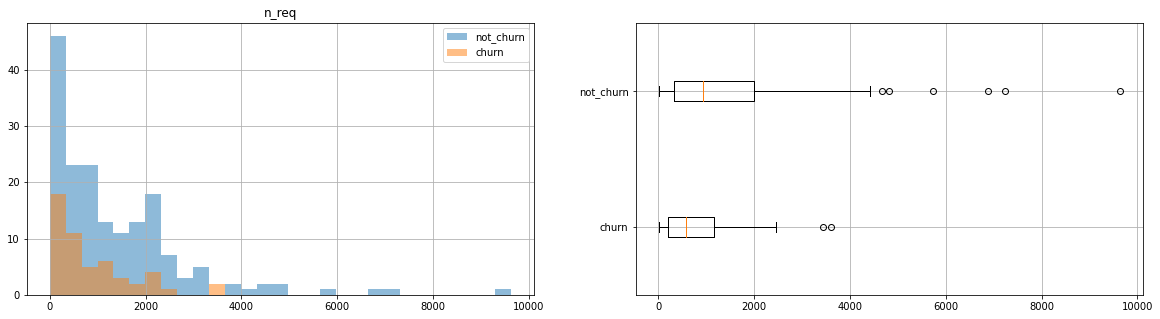

,n_session_churn,n_session_not_churn
count,52.000000,173.000000
mean,10.326923,15.254335
std,8.610803,15.866963
min,1.000000,1.000000
25%,5.000000,6.000000
50%,8.500000,11.000000
75%,12.000000,19.000000
max,37.000000,107.000000


t_stat = -2.1442082031269027, p_value = 0.03201620809858628


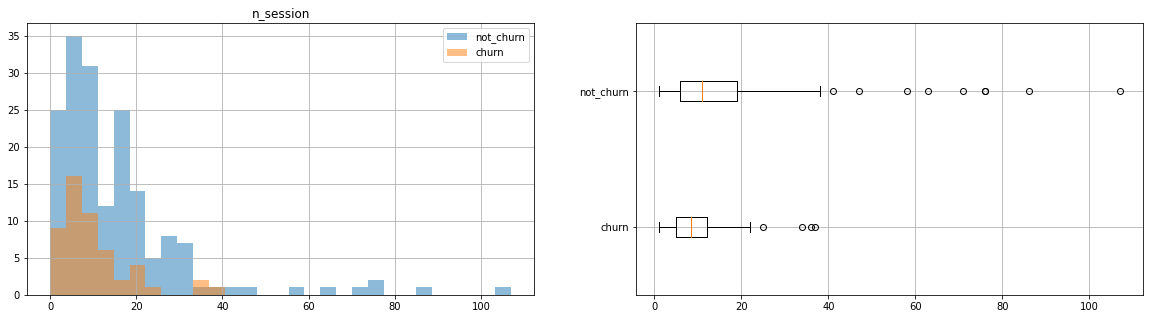

,n_artist_churn,n_artist_not_churn
count,52.000000,173.000000
mean,518.692308,749.786127
std,455.914317,633.235440
min,8.000000,3.000000
25%,143.000000,226.000000
50%,385.500000,587.000000
75%,762.250000,1137.000000
max,1804.000000,3544.000000


t_stat = -2.4462344850122135, p_value = 0.014435708075618723


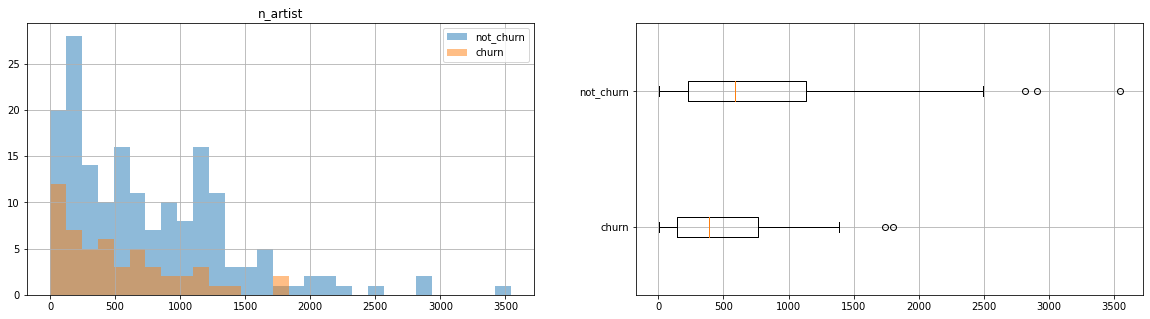

,n_song_churn,n_song_not_churn
count,52.000000,173.000000
mean,638.365385,975.768786
std,619.598669,951.912881
min,8.000000,3.000000
25%,147.000000,239.000000
50%,432.500000,696.000000
75%,901.500000,1477.000000
max,2562.000000,5946.000000


t_stat = -2.405345661505821, p_value = 0.016157175150150117


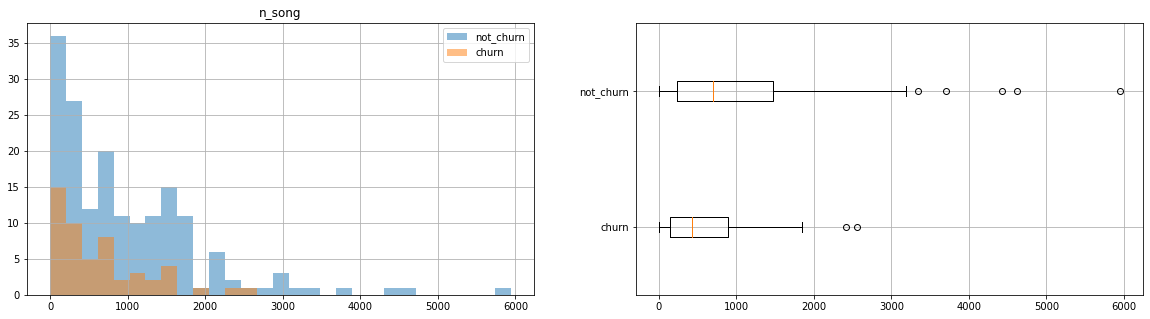

,ser_days_churn,ser_days_not_churn
count,52.000000,173.000000
mean,57.305993,86.620619
std,36.633148,35.348642
min,5.165116,0.313727
25%,30.801238,65.165150
50%,51.289392,75.463391
75%,73.751444,102.761921
max,188.311782,256.377674


t_stat = -5.199972526794912, p_value = 1.993179854075876e-07


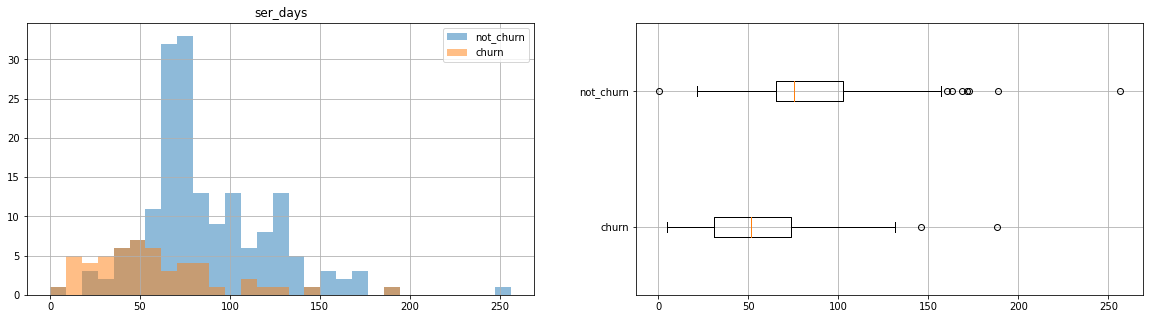

,avg_length_churn,avg_length_not_churn
count,52.000000,173.000000
mean,248.307865,249.141254
std,7.703952,5.312185
min,225.188117,230.556280
25%,245.261818,246.803473
50%,248.280670,249.168126
75%,251.645085,251.242991
max,267.767142,267.271383


t_stat = -0.8864481773717247, p_value = 0.3753760678512853


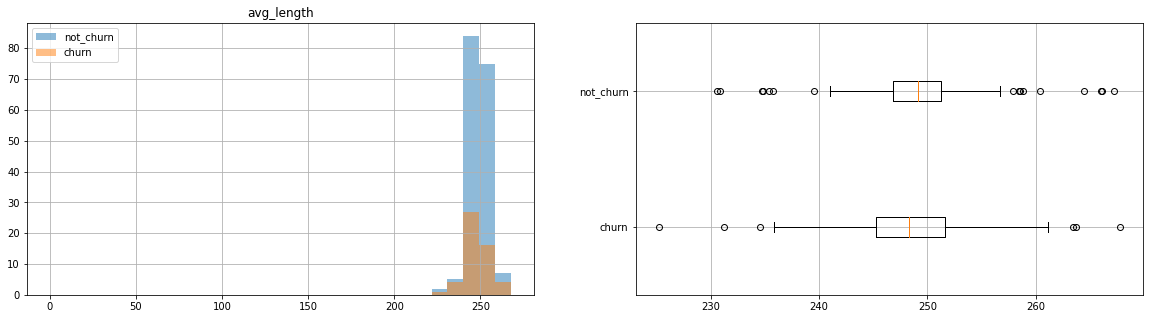

,n_thumb_up_churn,n_thumb_up_not_churn
count,52.000000,173.000000
mean,35.750000,61.803468
std,39.697817,70.416424
min,0.000000,0.000000
25%,9.500000,14.000000
50%,19.500000,41.000000
75%,45.000000,84.000000
max,163.000000,437.000000


t_stat = -2.5465799259653137, p_value = 0.010878429674667203


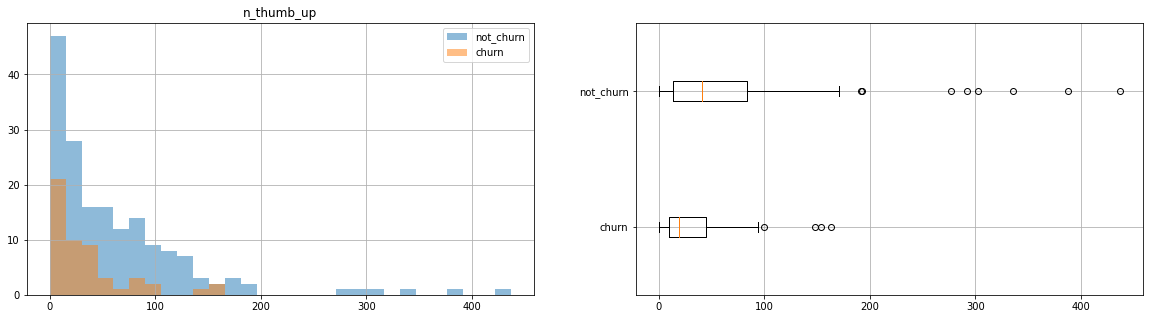

,n_thumb_down_churn,n_thumb_down_not_churn
count,52.000000,173.000000
mean,9.538462,11.849711
std,9.088803,14.035274
min,0.000000,0.000000
25%,2.000000,2.000000
50%,7.000000,8.000000
75%,15.250000,17.000000
max,36.000000,75.000000


t_stat = -1.118146317722026, p_value = 0.2635045071940475


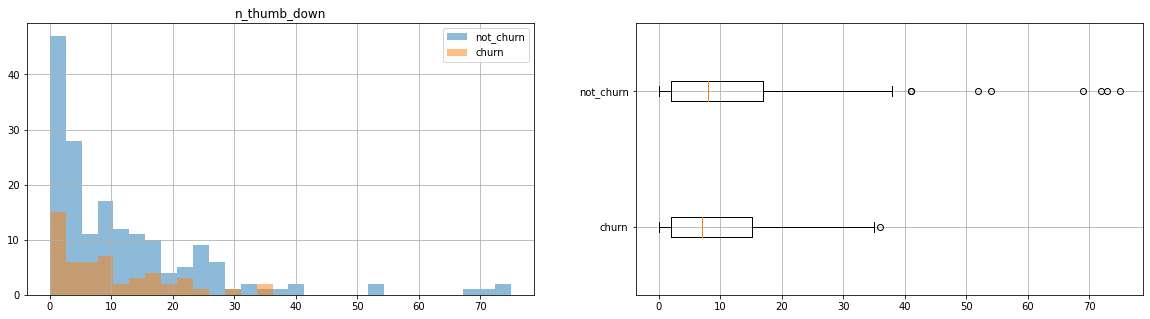

In [20]:
numerical_features = [
    'n_req', 'n_session', 'n_artist', 'n_song', 'ser_days', 'avg_length', 'n_thumb_up', 'n_thumb_down'
]
df_churn = df_user_summary_pd[df_user_summary_pd.is_churn==1]
df_nchurn = df_user_summary_pd[df_user_summary_pd.is_churn==0]
for c in numerical_features:
    display(HTML(f'<h3>{c}</h3>'))
    df_feature_stat = pd.concat([df_churn[c].describe(), df_nchurn[c].describe()], axis=1)
    df_feature_stat.columns = [f'{c}_churn', f'{c}_not_churn']
    display(HTML(df_feature_stat.to_html()))
    t_stat, p_value = ztest(df_churn[c], df_nchurn[c], 0, alternative='two-sided')
    print(f't_stat = {t_stat}, p_value = {p_value}')
    fig, axes = plt.subplots(1,2,figsize=(20, 5))
    ax_hist = axes[0]
    ax_box = axes[1]
    ax_hist.set_title(c)
    bins = np.linspace(0, df_user_summary_pd[c].max(), 30)
    ax_hist.hist(df_nchurn[c], bins=bins, label='not_churn', alpha=0.5)
    ax_hist.hist(df_churn[c], bins=bins, label='churn', alpha=0.5)            
    ax_box.boxplot([df_churn[c], df_nchurn[c]], labels=['churn', 'not_churn'], vert=False)
    ax_hist.legend()
    for ax in axes:        
        ax.grid()
    plt.show()
    plt.close()

As can be seen from graphs above
  - Churned users and Stayed users have signification difference in (confidence level 95%): ser_days, n_req, n_session, n_artist, n_song, n_thumb_up
  - The first 2 months is the time that churn ratio is high.
  - thumb_down and avg_length seems have no really difference between Churned users and Stayed users

## 2.2.2 Categorical features

,gender,is_churn,cnt
0,F,0.0,84
1,F,1.0,20
2,M,0.0,89
3,M,1.0,32


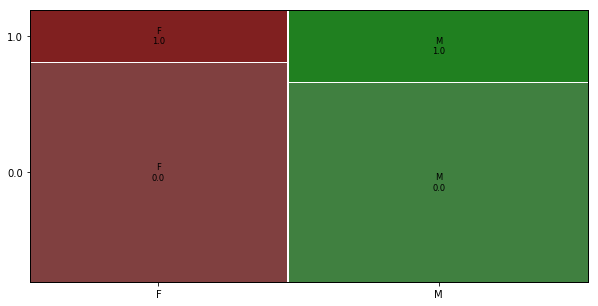

In [21]:
categorical_features = ['gender']
for c in categorical_features:
    display(HTML(f'<h3>{c}</h3>'))
    display(HTML(df_user_summary_pd.groupby([c, 'is_churn']).size().reset_index(name='cnt').to_html()))
    fig, ax = plt.subplots(figsize=(10, 5))    
    mosaic(df_user_summary_pd, [c, 'is_churn'], ax=ax)
    plt.show()
    plt.close()

# 3. Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [22]:
print('Number of null value on each features')
df_user_summary.select(
    [F.count(F.when(F.col(c).isNull() | F.col(c).eqNullSafe(''), 1)).alias(c) for c in df_user_summary.columns]
).show()

Number of null value on each features
+------+------+---------+--------+--------+--------+-----+---------+--------+------+--------+----------+----------+------------+
|userId|gender|firstName|lastName|location|is_churn|n_req|n_session|n_artist|n_song|ser_days|avg_length|n_thumb_up|n_thumb_down|
+------+------+---------+--------+--------+--------+-----+---------+--------+------+--------+----------+----------+------------+
|     0|     0|        0|       0|       0|       0|    0|        0|       0|     0|       0|         0|         0|           0|
+------+------+---------+--------+--------+--------+-----+---------+--------+------+--------+----------+----------+------------+



- The training data has no empty value so it is not necessary to handle null data
- The Feature Processing is done as below
  - One-hot Encode categorical features
  - Standard Scale numerical features
  - Assemble them into a vector to ready to train

In [23]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler, OneHotEncoder


numerical_features = [
    'n_req', 'n_session', 'n_artist', 'n_song', 'ser_days', 'avg_length', 'n_thumb_up', 'n_thumb_down'
]
category_features = ['gender']
category_features_idx = [f'{x}_idx' for x in category_features]
category_features_idx_ohe = [f'{x}_ohe' for x in category_features_idx]


pipeline = Pipeline(stages=[
    StringIndexer(inputCols=category_features, outputCols=category_features_idx),
    OneHotEncoder(inputCols=category_features_idx, outputCols=category_features_idx_ohe, handleInvalid='keep'),
    VectorAssembler(inputCols=numerical_features, outputCol='raw_vec'),
    StandardScaler(inputCol='raw_vec', outputCol='scaled_vec'),
    VectorAssembler(inputCols=['scaled_vec'] + category_features_idx_ohe, outputCol='features')    
])

In [24]:
pipeline_model = pipeline.fit(df_user_summary)
df_features = pipeline_model.transform(df_user_summary)

In [25]:
df_features.show(1)

+------+------+---------+--------+--------------------+--------+-----+---------+--------+------+------------------+-----------------+----------+------------+----------+--------------+--------------------+--------------------+--------------------+
|userId|gender|firstName|lastName|            location|is_churn|n_req|n_session|n_artist|n_song|          ser_days|       avg_length|n_thumb_up|n_thumb_down|gender_idx|gender_idx_ohe|             raw_vec|          scaled_vec|            features|
+------+------+---------+--------+--------------------+--------+-----+---------+--------+------+------------------+-----------------+----------+------------+----------+--------------+--------------------+--------------------+--------------------+
|    41|     F|    Brisa|  Murray|Manchester-Nashua...|     0.0| 2220|       12|    1319|  1699|110.77247685185185|250.2112403062302|        76|          10|       1.0| (2,[1],[1.0])|[2220.0,12.0,1319...|[1.66976084328160...|[1.66976084328160...|
+------+----

In [26]:
test_ratio = 0.3
train_data, test_data = df_features.randomSplit([1-test_ratio, test_ratio], seed=0)
train_data.cache()
test_data.cache()

DataFrame[userId: string, gender: string, firstName: string, lastName: string, location: string, is_churn: double, n_req: bigint, n_session: bigint, n_artist: bigint, n_song: bigint, ser_days: double, avg_length: double, n_thumb_up: bigint, n_thumb_down: bigint, gender_idx: double, gender_idx_ohe: vector, raw_vec: vector, scaled_vec: vector, features: vector]

In [27]:
train_data.groupby('is_churn').count().show()

+--------+-----+
|is_churn|count|
+--------+-----+
|     0.0|  110|
|     1.0|   40|
+--------+-----+



In [28]:
test_data.groupby('is_churn').count().show()

+--------+-----+
|is_churn|count|
+--------+-----+
|     0.0|   63|
|     1.0|   12|
+--------+-----+



# 4. Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## 4.1 Baseline with several model types

**We could try some models to have a sense which model work well, such as**
  - Linear Support Vector Classifier
  - Logistric Regression
  - Naive Bayes
  - Gradient Boosting Tree
  - Random Forest 
  - Multi-layer Perceptron


Given
  - TP: True Positive
  - TN: True Negative
  - FP: False Positive
  - FN: False Negative

**Evaluation metrics are defined as below**
  - Accuracy = (TP + TN) / (TP + TN + FP + FN)
  - F1 = TP / (TP + (FP+FN)/2)


In [29]:
def get_model_performance(model, train_data, test_data):
    pred_train = model.transform(train_data)
    pred_test = model.transform(test_data)
    evaluator = MulticlassClassificationEvaluator(labelCol='is_churn', predictionCol='prediction')
    acc_train = evaluator.evaluate(pred_train, {evaluator.metricName: "accuracy"})
    f1_train = evaluator.evaluate(pred_train, {evaluator.metricName: "f1"})
    acc_test = evaluator.evaluate(pred_test, {evaluator.metricName: "accuracy"})
    f1_test = evaluator.evaluate(pred_test, {evaluator.metricName: "f1"})
    return acc_train, f1_train, acc_test, f1_test

In [30]:
features_col = 'features'
label_col = 'is_churn'
input_size = len(train_data.take(1)[0].features)
svc = LinearSVC(featuresCol=features_col, labelCol=label_col)
lg = LogisticRegression(featuresCol=features_col, labelCol=label_col)
nv = NaiveBayes(featuresCol=features_col, labelCol=label_col)
gbt = GBTClassifier(featuresCol=features_col, labelCol=label_col, seed=0)
rf = RandomForestClassifier(featuresCol=features_col, labelCol=label_col, seed=0)
mlp = MultilayerPerceptronClassifier(featuresCol=features_col, labelCol=label_col, layers=[input_size, 10, 10, 2], seed=0)
evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol='prediction')
result = []
models = []
for clf in [svc, lg, nv, gbt, rf, mlp]:    
    class_name = clf.__class__.__name__
    model = clf.fit(train_data)
    acc_train, f1_train, acc_test, f1_test = get_model_performance(model, train_data, test_data)
    result.append((class_name, acc_train, f1_train, acc_test, f1_test))
    models.append(model)
    print(f'{class_name} | {acc_train:.3f} {f1_train:.3f} | {acc_test:.3f} {f1_test:.3f}')    

LinearSVC | 0.733 0.632 | 0.840 0.767
LogisticRegression | 0.780 0.750 | 0.827 0.796
NaiveBayes | 0.700 0.699 | 0.693 0.732
GBTClassifier | 1.000 1.000 | 0.787 0.787
RandomForestClassifier | 0.900 0.893 | 0.827 0.824
MultilayerPerceptronClassifier | 0.733 0.621 | 0.840 0.767


In [31]:
df_result = pd.DataFrame(result, columns=['clf', 'acc_train', 'f1_train', 'acc_test', 'f1_test'])
df_result.sort_values('f1_test', ascending=False)

,clf,acc_train,f1_train,acc_test,f1_test
4,RandomForestClassifier,0.900000,0.893088,0.826667,0.823581
1,LogisticRegression,0.780000,0.750433,0.826667,0.795542
3,GBTClassifier,1.000000,1.000000,0.786667,0.786667
0,LinearSVC,0.733333,0.632337,0.840000,0.766957
5,MultilayerPerceptronClassifier,0.733333,0.620513,0.840000,0.766957
2,NaiveBayes,0.700000,0.698780,0.693333,0.731587


As can be seen from above table, Random Forest give the best result here.

We can clearly see overfitting occurs here, which is the train result is signification higher than the test result.

To improve prediction result, I choose to tuning the best model, which is random forest to reduce the overfitting.

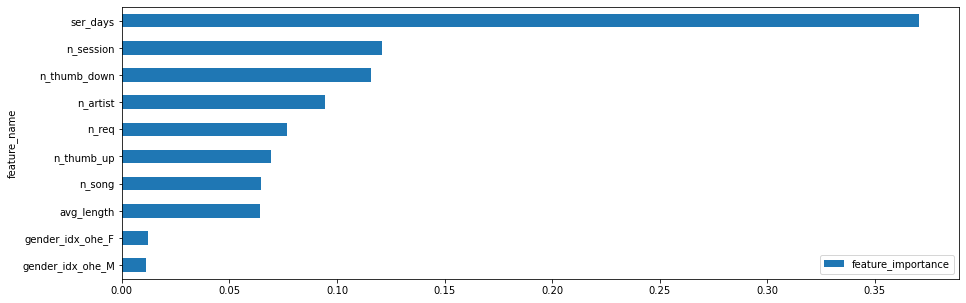

In [32]:
feature_map = {}
numeric_f = pipeline.getStages()[2].getInputCols()
attrs = train_data.schema["features"].metadata["ml_attr"]["attrs"]
for it in attrs['numeric']:
    feature_map[it['idx']] = numeric_f[it['idx']]
for it in attrs['binary']:
    feature_map[it['idx']] = it['name']

features_importance = models[4].featureImportances.toArray()
features_importance = [(feature_map[i], f) for i, f in enumerate(features_importance)]
df_features_importance = pd.DataFrame(features_importance, columns=['feature_name', 'feature_importance']).sort_values('feature_importance', ascending=True)
fig, ax = plt.subplots(figsize=(15, 5))
df_features_importance.plot.barh(x='feature_name', y='feature_importance', ax=ax)
plt.show()
plt.close()

We can clearly see that ser_days is the most important features. 

## 4.2 Tuning model

### RandomForest

Firstly, let's check the parameter of previous Random Forest

In [33]:
models[4].extractParamMap()

{Param(parent='RandomForestClassifier_29d705237495', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True,
 Param(parent='RandomForestClassifier_29d705237495', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='RandomForestClassifier_29d705237495', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='RandomForestClassifier_29d705237495', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supp

The previous Random Forest has params:
  - numTrees: 20
  - maxDepth: 5
  - minInstancesPerNode: 1
  - impurity: gini
  - maxBins: 32

To reduce overfitting, we could try to increase numTree, reduce maxDepth, increase minInstancesPerNode. Let's tuning Random Forest model.

In [34]:
rf = RandomForestClassifier(featuresCol=features_col, labelCol=label_col, seed=0)
paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [10, 20, 100])\
    .addGrid(rf.maxDepth, [3, 5, 7])\
    .addGrid(rf.minInstancesPerNode, [1, 3, 5])\
    .build()
crossval = CrossValidator(estimator=rf, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=MulticlassClassificationEvaluator(labelCol=label_col, predictionCol='prediction', metricName='f1'), 
                          numFolds=3)

In [35]:
cv_model = crossval.fit(train_data)

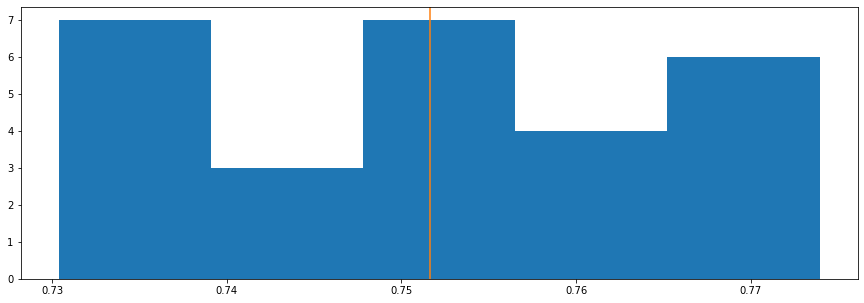

In [36]:
fig, ax = plt.subplots(figsize=(15,5))
ax.hist(cv_model.avgMetrics, bins=5)
ax.axvline(x=np.mean(cv_model.avgMetrics), color='tab:orange')
plt.show()
plt.close()

In [37]:
cv_model.bestModel.extractParamMap()

{Param(parent='RandomForestClassifier_a3d32b9b688d', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True,
 Param(parent='RandomForestClassifier_a3d32b9b688d', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='RandomForestClassifier_a3d32b9b688d', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='RandomForestClassifier_a3d32b9b688d', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supp

The best model after tuning has params
  - **numTrees: 100**
  - maxDepth: 5
  - **minInstancesPerNode: 3**
  - impurity: gini
  - maxBins: 32

In [38]:
acc_train_t, f1_train_t, acc_test_t, f1_test_t = get_model_performance(cv_model.bestModel, train_data, test_data)
df_result_after_tuning = df_result[df_result.clf=='RandomForestClassifier']
df_result_after_tuning = df_result_after_tuning.append(
    {'clf': 'RFTuning', 'acc_train': acc_train_t, 'f1_train': f1_train_t, 'acc_test': acc_test_t, 'f1_test': f1_test_t}, 
    ignore_index=True)
df_result_after_tuning

,clf,acc_train,f1_train,acc_test,f1_test
0,RandomForestClassifier,0.900000,0.893088,0.826667,0.823581
1,RFTuning,0.886667,0.877207,0.853333,0.850722


After tuning, the overfitting problem is reduced, the quality of model is signification increased in test data.

# 5. Conclusion

- **What I did**
  - Manipulate (load, clean, group) data with Pyspark
  - Do EDA to understand data and find pattern of churned user
  - Use Pyspark ML lib to do feature engineering, training and tuning model
    
- **Results**
  - Understand the pattern of churned user
  - Understand how to do preprocess and feature engineering with Pyspark
  - Archive Random Forest model which has high accuracy and F1 of 0.85

- **Discussions/Improvement**
  - The first 2 months is the time that churn ratio is high. So, we should do some campaign to keep the new users (such as, give them coupon, etc.)
  - The features may be bias by the time user remain. For example, the users do not churn, they stay long, so they have high request number. It should be considered to add statistical features in recent time (e.g request number of last week, number of unique song the user listen to last week, etc.)